<a href="https://colab.research.google.com/github/purekikan/Thai-Traditional-Music-Generation-with-LSTM/blob/main/TH_Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency & Functions

In [ ]:
#for training and data preprocessing
%tensorflow_version 2.x
import tensorflow as tf 
!pip install mitdeeplearning
import mitdeeplearning as mdl
import numpy as np
import pandas as pd
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1
import matplotlib.pyplot as plt

#for evaluating
!pip install fuzzywuzzy
!pip install python-Levenshtein
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
!pip install mutagen
import mutagen
from mutagen.wave import WAVE
import shutil
from pathlib import Path
import glob
from datetime import date
from IPython.display import Audio, display

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 34.8 MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-py3-none-any.whl size=2115441 sha256=f54dc4904ff8339cc34c55d36382422ffeb616c2adcf0f6bb13f4ac0d5fa8448
  Stored in directory: /root/.cache/pip/wheels/2e/45/44/c5b304f31f37e8d2315f9e969fd8cdb0014a5c28608d0bf410
Successfully built mitdeeplearning
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 21.6 MB/s 
     |████████████████████████████████| 2.2 MB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193 kB 

In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    LSTM(rnn_units), 
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

@tf.function
def train_step(x, y):
  with tf.GradientTape() as tape:
    y_hat = model(x)
    loss = compute_loss(y, y_hat)
  grads = tape.gradient(loss, model.trainable_variables)
  optmz[param_set].apply_gradients(zip(grads, model.trainable_variables))
  return loss

def generate_text(model, start_string, generation_length=1000):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])    
  return (start_string + ''.join(text_generated))

In [ ]:
def get_fzwz(generated_text, songs):
  fzwzscore_f = []
  fzwzscore_p = []
  for generated_song in mdl.lab1.extract_song_snippet(generated_text):
    
    full = [s[-1] for s in process.extract(generated_song, songs, scorer=fuzz.ratio, limit = len(songs))]
    partial = [s[-1] for s in process.extract(generated_song, songs, scorer=fuzz.partial_ratio, limit = len(songs))]

    fzwzscore_f.append(sum(full)/len(full))
    fzwzscore_p.append(sum(partial)/len(partial))
  return fzwzscore_f, fzwzscore_p
  
class mp3_converter():
    def __init__(self, path, ext, dirName):
        """Class that takes folder of music files of one file type, 
        converts them to mp3 and creates a new directory and moves them into it
        Input path of files that you would like to convert
        Extension of files you would like to convert i.e. WAV
        Folder name of the new directory you would like to create"""
        self.path = path
        self.ext = ext
        self.dirName = dirName

    def lower_underscore(self):
        """
        Converts all files in path to lowercase
        Replaces all spaces in filename with _
        """
        directory = self.path
        [os.rename(os.path.join(directory, f), os.path.join(directory, f).replace(' ', '_').lower()) for f in os.listdir(directory)]

    def mp3(self):
        """
        Converts all files in path with entered extension to mp3
        """
        directory = self.path

        for f in os.listdir(directory):
            if (f.endswith(self.ext)):
                os.system("ffmpeg -i {} -ar 44100 -ac 2 -b:a 192k {}/{}.mp3".format(
                    os.path.join(directory, f), directory, os.path.splitext(f)[0]))

    def make_dir(self):
        """
        Creates a directory for mp3's and moves all 
        previously created mp3's into it and moves the directory up one
        """
        mp3_directory = self.path + "/" + self.dirName
        if not os.path.exists(mp3_directory):
            os.makedirs(mp3_directory)
        for filename in os.listdir(self.path):
            if (filename.endswith(".mp3")):
                source = os.path.join(self.path, filename)
                dest = shutil.copy(source, mp3_directory)
                print(f"Moved {filename} to {dest}")

def evaluate_song(generated_text, param_set, train_set, date = date.today()):
  n = 0
  l = []
  generated_songs = mdl.lab1.extract_song_snippet(generated_text)
  for i, song in enumerate(generated_songs):
    waveform = mdl.lab1.play_song(song)
    if waveform:
      print("Generated song", i+1)
      
      song_name = f'{date}--{param_set}.{train_set}.{n+1}.wav'
      
      with open(song_name, 'wb') as f:
        f.write(waveform.data)
      audio = WAVE(song_name)
      length = int(audio.info.length)
      l.append(length)
      n+=1

  wav_play_rate = n/len(generated_songs)*100
  gensonglen_avg = sum(l)/len(l)
  gensonglen_min = min(l)
  
  return wav_play_rate, gensonglen_avg, gensonglen_min

def save_song(dir = '/content/mp3'):
  conv = mp3_converter('/content', ".wav", dir)
  conv.lower_underscore()
  conv.mp3()
  conv.make_dir()

def save_config(param_set, train_set, date=date.today()):
  ckpt_dir = f'drive/MyDrive/Project_M.5/Project-M.5/LSTM/ckpt/{date}--{param_set}.{train_set}/'
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
  for i in os.listdir("/content/training_checkpoints"):
    shutil.copy("/content/training_checkpoints/" + i, '/content/' + ckpt_dir + i)
  save_song(ckpt_dir)
  mp3_wavs = glob.glob("./*.wav")
  mp3_wavs.extend(glob.glob("./*.mp3"))
  for x in mp3_wavs:
    os.remove(x)

def train(num_training_iterations):
  for iter in tqdm(range(num_training_iterations)):
    x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
    loss = train_step(x_batch, y_batch)
    if iter % 100 == 0:     
      model.save_weights(checkpoint_prefix)
  model.save_weights(checkpoint_prefix)

# Download Dataset

In [ ]:
!git clone https://github.com/purekikan/Thai-Traditional-Music-Generation-with-LSTM.git

Cloning into 'Thai-Traditional-Music-Generation-with-LSTM'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [ ]:
songs = []
n=0

for x in glob.glob("/content/Thai-Traditional-Music-Generation-with-LSTM/Dataset/*.mid"):
  abc = !midi2abc {x} -k -2 -m 2/2 -title {n}
  abc_list = []
  for x in abc:
    if not x.startswith(("V:", "%")):
      abc_list.append(x.split(' %')[0])
  
  abc_prcesd = f'X: {n}'+'\n'.join(abc_list)[4:]+'!'
  print(abc_prcesd)
  songs.append(abc_prcesd)
  n+=1

X: 0
T: 0
M: 2/2
L: 1/8
Q:1/4=50
K:Bb
B,/2C/2D/2F/2 C3D C2| \
B,/2C/2D/2-[F/2D/2] C/2D/2C/2B,/2 CD F2| \
D/2F/2G/2B/2 F2 D/2C/2B,/2C<DF/2| \
GB c/2d/2c/2B/2 GB F2-|
F3F G/2B/2c/2d<GF/2| \
d3/2F<GF/2 G/2B/2c/2B/2 F2-| \
F2- F/2f/2d/2c/2 Bc d2-| \
dB c/2d/2c/2B/2 cd B2|
B,/2C/2D/2F/2 C3D C2| \
B,/2C/2D/2-[F/2D/2] C/2D/2C/2B,/2 CD F2| \
D/2F/2G/2B/2 F2 D/2C/2B,/2C<DF/2| \
GB c/2d/2c/2B/2 GB F2-|
F3F G/2B/2c/2d<GF/2| \
d3/2F<GF/2 G/2B/2c/2B/2 F2-| \
F2- F/2f/2d/2c/2 Bc d2-| \
dB c/2d/2c/2B/2 cd B2|!
X: 1
T: 1
M: 2/2
L: 1/8
Q:1/4=50
K:Bb
x3/2
F/2 F/2F/2G/2F/2 D/2FGB3/2-| \
BF/2G/2 F/2B/2F/2G/2 F/2B/2D/2C/2 F/2D3/2-| \
DF/2B,/2 C/2D/2C/2D/2 F/2D/2C/2B,C3/2-| \
CF/2B,/2 C/2D/2C/2D/2 F/2D/2C/2B,CF/2-|
F/2GBcd/2 f/2c/2d/2c/2 B/2GB,/2| \
C/2DFG/2F/2G/2 B/2GFF3/2-|F3!
X: 2
T: 2
M: 2/2
L: 1/8
Q:1/4=60
K:Bb
d/2c/2A/2c/2 A/2G<=EG/2A/2c/2 G2| \
d/2c/2A/2c/2 A/2G/2=E/2G/2 =E/2D/2C/2D/2 C2| \
g=e d=e/2g/2 =e/2d/2c/2d/2 =e2| \
g=e d=e/2g/2 =e/2d/2c/2d/2 c2|
F/2F/2F =ED3/2A/2c/2A/2 G2| \
F/2F/2F =ED3/2g/

In [ ]:
songs_joined = '\n\n'.join(songs)
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 45 unique characters in the dataset


# Process the Dataset

In [ ]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

In [ ]:
vectorized_songs = vectorize_string(songs_joined)

In [ ]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1
  idx = np.random.choice(n-seq_length, batch_size)
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

# Train the Model

In [ ]:
#@title Setting Parameters
num_training_iterations = 2000
batch_size = 40
seq_length = 115
learning_rate = 5.00e-03
embedding_dim = 256
rnn_units = 600
generation_length = 5000
param_set = 1
vocab_size = len(vocab)
optmz = {}
optmz[1] = tf.keras.optimizers.Adam(learning_rate)
optimizer = optmz[1]
start_string = "X: 0\nT: 0\nM: 2/2\nL: 1/8\nQ:1/4=100\nK:Bb"
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

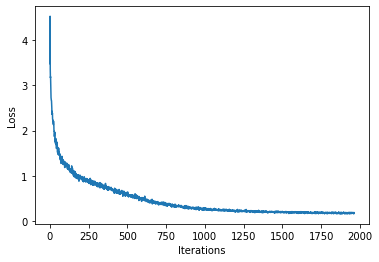

100%|██████████| 5000/5000 [00:28<00:00, 176.64it/s]


Found 4 songs in text
Found 4 songs in text
Generated song 1
Generated song 2
Generated song 3
Generated song 4


'./2022-12-25--test.test.1.wav'

'./2022-12-25--test.test.2.wav'

'./tmp.wav'

'./2022-12-25--test.test.3.wav'

'./2022-12-25--test.test.4.wav'

Moved 2022-12-25--test.test.3.mp3 to /content//content/mp3/2022-12-25--test.test.3.mp3
Moved 2022-12-25--test.test.4.mp3 to /content//content/mp3/2022-12-25--test.test.4.mp3
Moved 2022-12-25--test.test.2.mp3 to /content//content/mp3/2022-12-25--test.test.2.mp3
Moved tmp.mp3 to /content//content/mp3/tmp.mp3
Moved 2022-12-25--test.test.1.mp3 to /content//content/mp3/2022-12-25--test.test.1.mp3


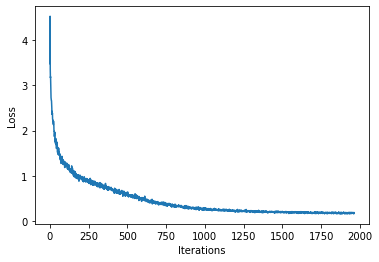

In [ ]:
#@title Train the model and generate songs!
score = 0
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'):
  tqdm._instances.clear()
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
print("--------Start Training--------")
for iter in tqdm(range(num_training_iterations)):
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)
  history.append(loss.numpy().mean())
  plotter.plot(history)

  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
model.save_weights(checkpoint_prefix)

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
generated_text = generate_text(model, start_string=start_string, generation_length= generation_length)
fzwz = get_fzwz(generated_text, songs)
try:
  other_metrics = evaluate_song(generated_text, "test", "test")
except:
  print('no song is generated')
  other_metrics = [0,0,0]
  fzwz = [[0],[0]]
save_song("mp3")
for song_name in glob.glob("./mp3/*.mp3"):
  display(Audio(song_name))